## <span style="color:blue"> Computer Vision - Winter 2024

## <span style="color:blue"> Exercise 2 </span>
**Reichman University**

**Lecturer:** Prof. Yael Moses, RUNI

**TA:** Eyal Friedman, RUNI

**Submission date: 25.1.24** \
Note: In case you need an extension for any reason, you can submit it by 29.1.24. \
No extra extensions will be given.
In case you are in miluim - please contact Yael directly.

**Your name: [Omer Yaffe]**
**Your ID: [204004121]**

In this exercise, you will implement: 
    
1. Straight line detection from image features using  Hough Transform.
2. Various feature matching.
3. Computing depth from rectified images.


## <span style="color:blue"> Submission guidelines:</span>

1. Your **zip** file should include the following files only:
   - ex2.ipynb
   - images you use that were not given 
2. You should use Jupyter Notebook.
3. Name the zip file **'ex2_ID_ID.zip'** and **do not** include any additional directories.
4. Submit using *Moodle*.
5. Submit on time!
6. You can submit this assignment in pairs (no triplets).
   * In the case of pair submission, both IDs and names should be added to the notebook.
   * One should submit the homework, and the other should submit a simple text file named: ID_ID.txt and nothing else.
   *Please make sure that your collaborator submits the HW.

## Read the following instructions carefully:

1. Write **efficient vectorized** code. When you think you cannot use vectorized code, give a short explanation of why.
2. You are responsible for the correctness of your code and should add as many tests as you see fit. Do not submit your tests unless requested.
3. Use `Python 3` and `numpy 1.18.5` or above. Changes to the configuration we provided are at your own risk. Before submitting the exercise, restart the kernel and run the notebook from start to finish to make sure everything works.
4. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. Any other imports are forbidden unless provided by us.
5. Your code must run without errors. Note, **Code that fails to run will not be graded.**
6. Document your code properly.
7. Go over Warmup Python - you can find relevant python functions that will make your life easier.



## Honor Code:
The assignment is a basic tool for learning the material. You can probably find the solution on the web (including ChatGPT), however, you will not learn what you should learn from it. In addition, since we give grades on the assignment, using existing solutions will be considered dishonest.
In particular, you are not allowed to copy or use any code that solve the tasks. 
You are more than welcome to talk with your friends, but you are not allowed to give your code or answers and you are not allowed to use their code or answers. 
Remember – you take this course in order to learn.

## I declair that I respcet the honor code:
<span style="color:red"> Add here your names: Omer Yaffe


In [1]:
import cv2


from matplotlib import pyplot as plt

# This opens an inteactive figure - use it in part B
import matplotlib
matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import null_space
from scipy.signal import convolve2d

# This specifies the way plots behave in jupyter notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'


import platform
print("Python version: ", platform.python_version())
print("Numpy version: ", np.__version__)

Python version:  3.8.5
Numpy version:  1.21.6




## <span style="color:blue">Section A: Detect a Straight Lines

In this part you will use the set of edge points to detect straight lines in an image.\
The input will consist of edge points computed by the Canny edge detector - you can use the implementation of CV2, which is demonstrated below.\
    The output will be a set of straight lines in the image. There are two main methods to compute straight lines from such input: the Hough transform and RANSAC. You will implement the Hough transform.

    

**Hough transform**\
Every 2D line, $\ell$,   can be represented by 2 parameters:  $r$ and $\theta$ where all points on the lines satisfy $r=(xcos\theta, ysin\theta)$. 
Let $P_0=(x_0,y_0)$ be the intersection of a normal to $\ell$ from the origin.
The distance between $P_0$ and the origin is given by $r$ and the angle between the normal and the $x$ axis is given by $\theta$. 






**Your goal:**     Write the following function\
Straight_lines(image_file, res_r, res_orient,min_number_points,display,  ...)\
    You can add any other parameters that you need.
    


 To do so, you need also to define the following functions. 
 You can add parameters to the functions, as long as you  provide clear explanations of their roles and purposes.

In [2]:
# Input: a set of edge points (or corners), and the resolution of the distance and angles. 
# output: the Hough matrix (H) containing votes for lines represented by r and θ.
def H_matrix(L_points, resolution_r, resolution_ang):
    
    # Get X,Y locations from 
    X_values, Y_values = np.nonzero(L_points)
    
    # Create array of angles according to the specified angle resolution
    thetas = np.deg2rad(np.arange(-90.0, 90.0, resolution_ang))
    Image_diag = int(round(np.sqrt(L_points.shape[0]**2 + L_points.shape[1]**2)))
    R_distances = np.arange(-Image_diag,Image_diag,resolution_r)
    Cos_theta = np.cos(thetas)
    Sin_theta = np.sin(thetas)
    accumalor_mat = np.zeros((len(R_distances),len(thetas)), dtype=np.uint64)
    for X_p,Y_p in zip(X_values, Y_values):
        for idx in range(0,len(Cos_theta)):
            R_Calculated = int(round((X_p)*Cos_theta[idx]+ (Y_p) *Sin_theta[idx]))
            R_ind = np.argmin(np.abs(R_Calculated - R_distances))
            accumalor_mat[R_ind ,idx] += 1

    return accumalor_mat,R_distances,thetas

def  list_lines(H,th,R_distances,thetas):
# th - number of minimal points on the line
    list_of_lines = [ ] 
    indices = np.where(H.flatten() > th)
    for index in indices[0]:
      r = R_distances[index // H.shape[1]]
      theta = thetas[index % H.shape[1]]
      num_points = H.flatten()[index]
      list_of_lines.append((r, theta, num_points))
    return list_of_lines

# Display the detected lines in red - overlaid the original image
# Note: one way to do is, is to add the red lines to the image, and then display it
def display_lines(im,list_lines):
    imC = np.dstack([im,im,im]) 
    for line in list_lines:
        r,theta,_ = line
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * r
        y0 = b * r
        x1 = int(x0 + 2000 * (-b))
        y1 = int(y0 + 2000 * (a))
        x2 = int(x0 - 2000 * (-b))
        y2 = int(y0 - 2000 * (a))
        cv2.line(imC, (y1, x1), (y2, x2), (0, 0, 255), 2)
    return imC

In [ ]:
#Now use the above functions to implement 
def straight_lines(image_file,Image_title, res_r, res_orient,min_number_points,display):
    
    # Import image
    img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

    # Get edges
    edges = cv2.Canny(img,250,500,5)

    # Calculate Hough matrix
    accumalor_mat,R_distances,thetas = H_matrix(edges, res_r, res_orient)

    # Find lines
    list_of_lines = list_lines(accumalor_mat,min_number_points,R_distances,thetas)
    
    # Display lines
    image_with_lines = display_lines(img,list_of_lines)

    # Display results  
    if display:
        image_with_lines_rgb = cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB)
        f, ((ax1, ax2)) = plt.subplots(1, 2, sharex='col', sharey='row')
        ax1.imshow(img), ax1.set_title(f'Image - {Image_title}')
        ax2.imshow(image_with_lines_rgb), ax2.set_title(f'Image with straight lines - {Image_title}')
        plt.show()
    return list_of_lines

**Apply and answer**

1. Generate a synthetic image to test your Hough Transform algorithm. 
   * Submit the image as well as the results.


2. Apply your algorithm to the following images: Crosswalk, linesOnTheRoadGray, Sudoku. 
   * Choose a set of parameters so the results looks fine.
   * You may need different parameters for each image.
   * Display the results.
   
   
3. **Answer**: How the resolutions of $r$ and $\theta$ affect the results?
   * Display images that demonstarte your answer.
   
   
4. Choose one image and **answer**: how many straight lines did you find with more than 50 points?
   * Display these lines on the image.
   
   
5. Suggest an algorithm to compute the length of the line in the image.
   * Describe the algorithm without implementing it.
   
   
6. Suggest three applications to use the results of straight line detection in an image.



In [ ]:
# -------------------------------Question 1-------------------------------

# Generattion a synthetic image for testing my Hough Transform algorithm
image = np.zeros((500, 500), dtype=np.uint8)
cv2.line(image, (400, 10), (30, 400), 255, 8)

# Get edge by Canny
edges = cv2.Canny(image,250,500,5)

# Calculate Hough matrix
accumalor_mat,R_distances,thetas = H_matrix(edges, 1,  1)
list_of_lines = list_lines(accumalor_mat,160,R_distances,thetas)

# Display lines
image_with_lines = display_lines(image,list_of_lines)
image_with_lines_rgb = cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB)

# Display results
f, ((ax1, ax2 , ax3)) = plt.subplots(3, 1,gridspec_kw={'hspace': 0.5})
ax1.imshow(image,aspect='auto'), ax1.set_title('Synthetic image')
ax2.imshow(accumalor_mat,aspect='auto'), ax2.set_title('Accumalor matrix')
ax3.imshow(image_with_lines_rgb,aspect='auto'), ax3.set_title('Algo results')
plt.show()

In [ ]:
# -------------------------------Question 2-------------------------------
straight_lines(image_file = '.\images\Crosswalk.jpg',Image_title = 'rosswalk', res_r = 2, res_orient = 1 ,min_number_points = 250,display = 1)
straight_lines(image_file = '.\images\linesOnTheRoadGray.jpg',Image_title = 'linesOnTheRoadGray', res_r = 0.5, res_orient = 1 ,min_number_points = 70,display = 1)
straight_lines(image_file = '.\images\Sudoku.PNG',Image_title = 'Sudoku', res_r = 10, res_orient = 10 ,min_number_points = 800,display = 1)

-------------------------------Question 3-------------------------------
- Higher resolution for r allows the algorithm to consider a larger number of possible distances from the origin for each detected line.
This can lead to more accurate detection of lines with various distances,
but it comes at the cost of increased computational complexity.
- Higher resolution for θ allows the algorithm to consider a larger number of possible angles for each detected line.
This can improve the detection of lines with various orientations but increases computational complexity.

In [ ]:
# Demonstration of the resolutions of r and theta on the results 
straight_lines(image_file = '.\images\linesOnTheRoadGray.jpg',Image_title = 'linesOnTheRoadGray \n resolution of r $\\mathbf{{{= 1}}}$', res_r = 1, res_orient = 1 ,min_number_points = 70,display = 1)
straight_lines(image_file = '.\images\linesOnTheRoadGray.jpg',Image_title = 'linesOnTheRoadGray \n resolution of r $\\mathbf{{{= 3}}}$', res_r = 3, res_orient = 1 ,min_number_points = 70,display = 1)

It can be observed that when i run the algorithm with a better resolution (r = 1) i recieved more accurate results.
The disadvantage is that it took me more time, beacuse it required more computional iterations.

In [ ]:
straight_lines(image_file = '.\images\linesOnTheRoadGray.jpg',Image_title = 'linesOnTheRoadGray \n resolution of theta $\\mathbf{{{= 1}}}$', res_r = 1, res_orient = 1 ,min_number_points = 70,display = 1)
straight_lines(image_file = '.\images\linesOnTheRoadGray.jpg',Image_title = 'linesOnTheRoadGray \n resolution of theta $\\mathbf{{{= 10}}}$', res_r = 1, res_orient = 10 ,min_number_points = 70,display = 1)

It can be observed that when i run the algorithm with a better theta resolution (theta = 1 [Deg]) i recieved more accurate results.
The disadvantage is that it took me more time, beacuse it required more computional iterations.

In [ ]:
# -------------------------------Question 4-------------------------------
List_Of_lines = straight_lines(image_file = '.\images\linesOnTheRoadGray.jpg',Image_title = 'linesOnTheRoadGray', res_r = 0.5, res_orient = 1 ,min_number_points = 50,display = 1)
print(f'I found {np.shape(List_Of_lines)[0]} lines with more than 50 points.')

-------------------------------Question 5-------------------------------

Algorithm suggestion for computing the line length:
1) For each element in the Hough matrix save also the X,Y coordinates so for each element at the Hough matrix you will have 2D array of X,Y coordinates.
2) Choose one element from the Hough matrix.
3) Create an array of all pairwise distances (Euclidean distance).
4) Find the indices of the maximum distance.
5) Extract the two points with the maximum distance (Euclidean distance).
6) This distance will be the length of the line. 

-------------------------------Question 6-------------------------------
1) Identifying lane markings on roads is crucial for autonomous vehicles to navigate.
2) Detecting straight lines in images can help robots identify structures like walls, doorways, and furnitures.
3) Detecting straight lines can be used to rectify distorted document images, align text lines, and extract meaningful content.

## <span style="color:blue">Section B: Patch Matching
**In this part you will match intrest points between two images.**
    
    
There are two functions between vectors $v$ and $u$ that you will consider:\
a. Distance: Sum of Square Distance (SSD). That is,  $SSD(u,v)=(u-v)\cdot(u-v)$.\
b. Similarity: Normalized Cross Correlation (NCC). That is,  $NCC(u,v)={u\cdot v \over ||u||||v||}$.


The patch descriptor:
1. A vector with the pixels' grey level.
2. An histogram (30 bins) of the pixels' grey level.
3. A vector with the pixels' strength gradient.
4. An histogram (30 bins) of the pixels' strength of gradient. 


In [5]:
#Implement the following functions:

# Input: two vectors
# Output distance (scalar) between two patches

def  SSD(patch_descr_1, patch_descr_2):
    return ((patch_descr_1-patch_descr_2)**2).sum()

# Input: two vectors
# Output normalized cross correlation  (scalar) between two patches

def NCC(patch_descr_1, patch_descr_2):
    return (patch_descr_1*patch_descr_2).sum() / np.sqrt((patch_descr_1**2).sum()*(patch_descr_2**2).sum())

# Output a descriptor vector 
# im is an image, p is a pixel, size is the patch size.
# You can use the histogram function of open cv or numpy

def patch_from_im(im,p,size):
    return im[p[0]-size:p[0]+size+1,p[1]-size:p[1]+size+1].flatten()

def hist_patch_im(im,p,size):
    return np.histogram(patch_from_im(im,p,size), bins=10, range=(0, 255))[0]

def gradient(im,p,size):
    # Define Sobel filters
    sobel_filter_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_filter_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    # Convolve the image with Sobel filters
    gradient_x = convolve2d(image, sobel_filter_x, mode='same', boundary='symm')
    gradient_y = convolve2d(image, sobel_filter_y, mode='same', boundary='symm')

    # Compute the magnitude of the gradient
    return np.sqrt(gradient_x**2 + gradient_y**2)

def  hist_gradient(im,p,size):
    return np.histogram(gradient(im,p,size), bins=10, range=(0, 255))[0]

**Apply and answer**


1. Compute the corners in a pair of images (e.g., view0.tif and view6.tif).


2. Choose up to 2000 of the strongest corners (you can use fewer) and find a matching between the corners in the pair of images.
    * Choose a fixed scale and use it to define a patch around each corner.
    * To display the matching, use the function cv2.hconcat([im1, im2]), which concatenates two images horizontally, and then draw lines as described in the previous section.


3. Use up to 4000 of the strongest corners (you can use fewer) in each image and use the matching only between corners that have approximately the same y-coordinate (up to a threshold).


4. Study the ratio for matching between the best and the second best match. 
   * You can use NCC or SSD on the desriptor of your choice.
   * You can use without (2) or with (3) the $y$-coordinate constraint.
   * **Present** examples that demonstrate the effectiveness of using the ratio.


5. Study the differences between the different descriptors and also the use of SSD or NCC. 
   * **Present**  examples that demonstrate your findings.


6. Identify incorrect pairs of matched points.\
   **Mark and display** for cases (2), (3), and (4) a pair of incorrectly matched points.\
   **Answer**\
   a. In which of the 3 cases are there more incorrect matches?\
   b. What may be the reason for the incorrect matches?


7. In which regions of the scene were most of the reliable matches found?



**Implementation details**

You can compute the NCC or SSD patch by patch. This will probably takes longer than using matrix multiplications of numpy.

Using matrices:
1. Generate a 1D vector from each descriptor.


2. Generate a matrix $M_1$:  rows  are  the descriptors of img1.


3. Generate a matrix $M_2$:  columns  are  the descriptors of img2.


4. $M=np.matmul(M_1,M_2)$\
   * what is the value in $M(i,j)$?


5. Think of how to normalize the set of patches, if you need.
   * You can consider using the function np.diag(np.diag(matrix)) as part of your solution.
    
    

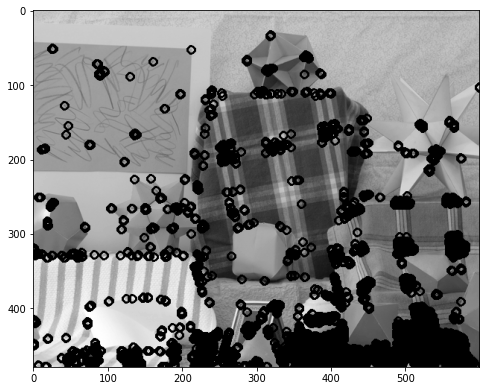

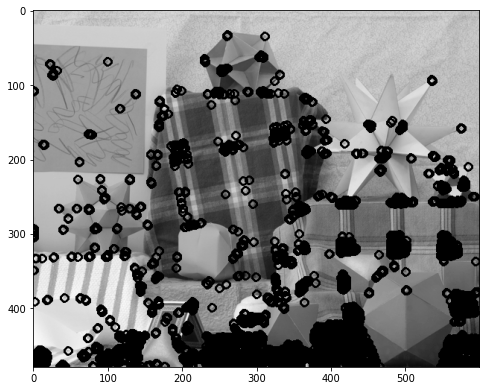

In [3]:
# Need to be reviewed, maybe i need to take it from my HW. 
# -------------------------------Question B1-------------------------------
view0 = cv2.imread(r'.\images\view0.tif', cv2.IMREAD_GRAYSCALE)
veiw6 = cv2.imread(r'.\images\view6.tif', cv2.IMREAD_GRAYSCALE)

block_size = 2  # Size of the neighborhood considered for corner detection
ksize = 5      # Aperture parameter of Sobel derivative used for corner detection
k = 0.06       # Harris detector free parameter (usually in the range [0.04, 0.06])
corner_response_view0 = cv2.cornerHarris(view0, blockSize=block_size, ksize=ksize, k=k)
corner_response_view6 = cv2.cornerHarris(veiw6, blockSize=block_size, ksize=ksize, k=k)
# Threshold the corner response to get the corner points
threshold_view0 = 0.001 * corner_response_view0.max()  # You can adjust this threshold value
threshold_view6 = 0.001 * corner_response_view6.max()  # You can adjust this threshold value
corner_points_view0 = np.argwhere(corner_response_view0 > threshold_view0)
corner_points_view6 = np.argwhere(corner_response_view6 > threshold_view6)
# Draw circles around detected corners
image_with_corners_view0 = view0.copy()
image_with_corners_view6 = veiw6.copy()
for point in corner_points_view0:
    cv2.circle(image_with_corners_view0, tuple(point[::-1]), 5, (0, 0, 255), 2)
for point in corner_points_view6:
    cv2.circle(image_with_corners_view6, tuple(point[::-1]), 5, (0, 0, 255), 2)

# Display the original image and the one with corners
plt.imshow(image_with_corners_view0)
plt.show()
plt.imshow(image_with_corners_view6)
plt.show()

In [18]:
strongest_corners_view6 = corner_points_view6[np.argsort(corner_response_view6[corner_points_view6[:, 0], corner_points_view6[:, 1]])[::-1]]
strongest_corners_view0 = corner_points_view0[np.argsort(corner_response_view0[corner_points_view0[:, 0], corner_points_view0[:, 1]])[::-1]]
size = 5
Num_of_patches = 200
descriptors_view0 = [patch_from_im(view0,pixel,size) for pixel in corner_points_view0[1:Num_of_patches]]
descriptors_view6 = [patch_from_im(veiw6,pixel,size) for pixel in corner_points_view6[1:Num_of_patches]]

In [21]:
import numpy as np

# Assuming descriptors_view0 is a list of 199 arrays, each with 121 elements
# descriptors_view0 = [np.random.randint(0, 255, 121, dtype=np.uint8) for _ in range(199)]

# Check if each array has exactly 121 elements
for array in descriptors_view0:
    print('okay')
    if len(array) != 121:
        print(array)
        raise ValueError("Each array must contain exactly 121 elements.")

# Add an array of zeros to make it a total of 200 arrays
descriptors_view0.append(np.zeros(121, dtype=np.uint8))

# Convert the list of arrays to a NumPy array
matrix_array = np.array(descriptors_view0)

# Reshape the array to have dimensions (200, 121)
matrix_array = matrix_array.reshape((200, 121))

# Check the shape
print("Shape of matrix_array:", matrix_array.shape)

okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
okay
[184 187 186 186 186 186 186 185 186 187 186 186 185 186 186 186 185 185
 186 186 186 186 186 181 187 186 186 186 186 157 186 187 186 189 169 136
 187 186 187 183 142 154 187 186 188 154 145 168 187 188 170 137 157 165
 187 181 143 145 160 157 187 156 137 159 165 151]


ValueError: Each array must contain exactly 121 elements.

In [ ]:
matrix1 = np.array([[1, 2 , 3],
                    [5, 6 , 7]])

matrix2 = np.array([[2, 1, 3],
                    [8, 1, 2]])

# Compute SSD for all pairs of patches using matrix operations
ssd_matrix = np.sum((matrix1[:, None, :] - matrix2[None, :, :])**2, axis=2)
# print(ssd_matrix)
# print(matrix2[None, :, :])
# print(np.shape(matrix1[None, :,:]))
x=(matrix1[:, None, :] - matrix2[None, :, :])

original_vector = np.array([1, 2, 3, 4],[5,6,7,8])

## Part C ## 

In this part you will compute the 3D structure from a pair of rectified images.


**The input:**\
    **a.** A pair of two rectified images, $im1$ and $im2$ (*view1.png and view5.png*).\
    **b.** A window size $(s_x,s_y$).\
    **c.** Disparity range $(d_{min},d_{max})$ (see below).

**The output:**\
**a.** A matrix, $D$ with the disparity map for the left image.\
**b.** Three matrices X, Y, Z with the x, y, z-coordinates of each pixel in the left image. Assign zero for pixels for which the disparity was not computed.

Note: all matrices $im1, im2, D, X, Y, Z$ have the same dimensions.

**Instructions:**
1. Read the two images view1.png and view5.png, and apply the functions to this pair of images.

   
2. Write a function that receives two rectified images, and compute dense matching along lines with the same $y-$coordinate.
    * You can use any of the descriptors from Part B. The patch size should be given as a parameter.
    * Use NCC for the similarity measure.
    * You can assume that you are given the range of disparities, $d_{min},d_{max}$ as an input. \
      For example, if  $(d_{min},d_{max})=(20,120)$ it follows that the corresponding point of  $(x,y)$ in the left image, is in the range $(x-120:x-20,y)$ in the right image.
    * Consider matching with and without order preseving. 
    * List all parameters you use for your function.
    * Hints on efficient implementation is given below.
    
        
3. Write a function that computes the disparity based on (2).  
    * **Display** the disparity $D$ map as an image
   
  
4. Compute the depth map using the disparity.
    * Assume that scaled focal lengths ($f$ in the presentation) are $α_x=α_y=1$.
    * The distance between the cameras is 160mm.
    * Add to your disparity depth map the value 100, since images were cropped. 
    * Display the disparity as an image. 
   

4. Compute the matrices X,Y,Z
    * Present the object given by X,Y,Z using a 3D plot.


**Implementation**\
You can implement the computation of the similarity and the disparity directly by an exhaustive search. You can also use the idea from Part B. A more efficeint and elegant way is described below. You are welcome to try, but you do not have to.


General idea for the **vectorized solution** (you will need to fill in the gaps):
* Let $w$ and $h$ we the width and the height of the image respectively.
* First assume that the patch size is $1\times s_y$.
* Given two $1\times w$ rows, $r_1$ and $r_2$ which are corresponding rows of the two images. Compute the $w\times w$ matrix $R12=r_1^T r_2$. The values $R12(i,j)$ consists of the product of two pixels $r_1(i)\cdot r_2(j)$.
* Convolve $R12$ with the $s_y\times s_y$ identity matrix, $I_{s_y}$ : $Corr=I_{s_y}*R12$. The value $Corr(i,j)$ is the correlation of the $s_y$ 1D neighborhood of $r_1(i)$ and  $r_2(j)$.
* Think about how to normalize this correlation using the same idea. Hint, use the computation of $I_{s_y}*(r_1^Tr_1)$ and $I_{s_y}*(r_2^Tr_2)$.
* For a general patch size, $s_x\times s_y$, define $R$ to be 3D matrix of size $h\times w\times s_x$ and use 3D mask for the convolution.
* Up to here, we considered each row seperately, hence we need to loop over all rows of the images. There is a way to do it without looping, but not in this assignemnt :)
